![Imgur](https://i.imgur.com/jPOaZ9H.png)

## ①　Introduction
The dataset consists of two features: an index and a label column (golf stock price).

🎯　Your goal is to **predict the stock price of the last 30 days**.


You are free to add/remove sections and made any modification to this notebook. Only your final submission will be graded. This notebook will not be graded.

## ②　Setting Up the Environment
These are some of the libraries used in the lecture.

In [1]:
# Basic Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy  as np
import random
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics         import accuracy_score, mean_squared_error, r2_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Time Series Analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

## ③　Loading (Training) Dataset

In [2]:
# Load the train dataset
train_url = "/kaggle/input/prediction-of-golf-daily-revenue/train.csv"
df_train = pd.read_csv(train_url, index_col='Date', parse_dates=True)

# Load the test dataset
test_url = "/kaggle/input/prediction-of-golf-daily-revenue/test.csv"
df_test = pd.read_csv(test_url, index_col='Date', parse_dates=True)

target_col = 'Score'

# Concatenate train and test
df = pd.concat([df_train[['Score']], df_test.assign(Score=np.nan)])

df

,Score
Date,
2022-01-01,63.939952
2022-01-02,64.078069
2022-01-03,64.660728
2022-01-04,64.921118
2022-01-05,64.975741
...,...
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN


## ④　Exploratory Data Analysis

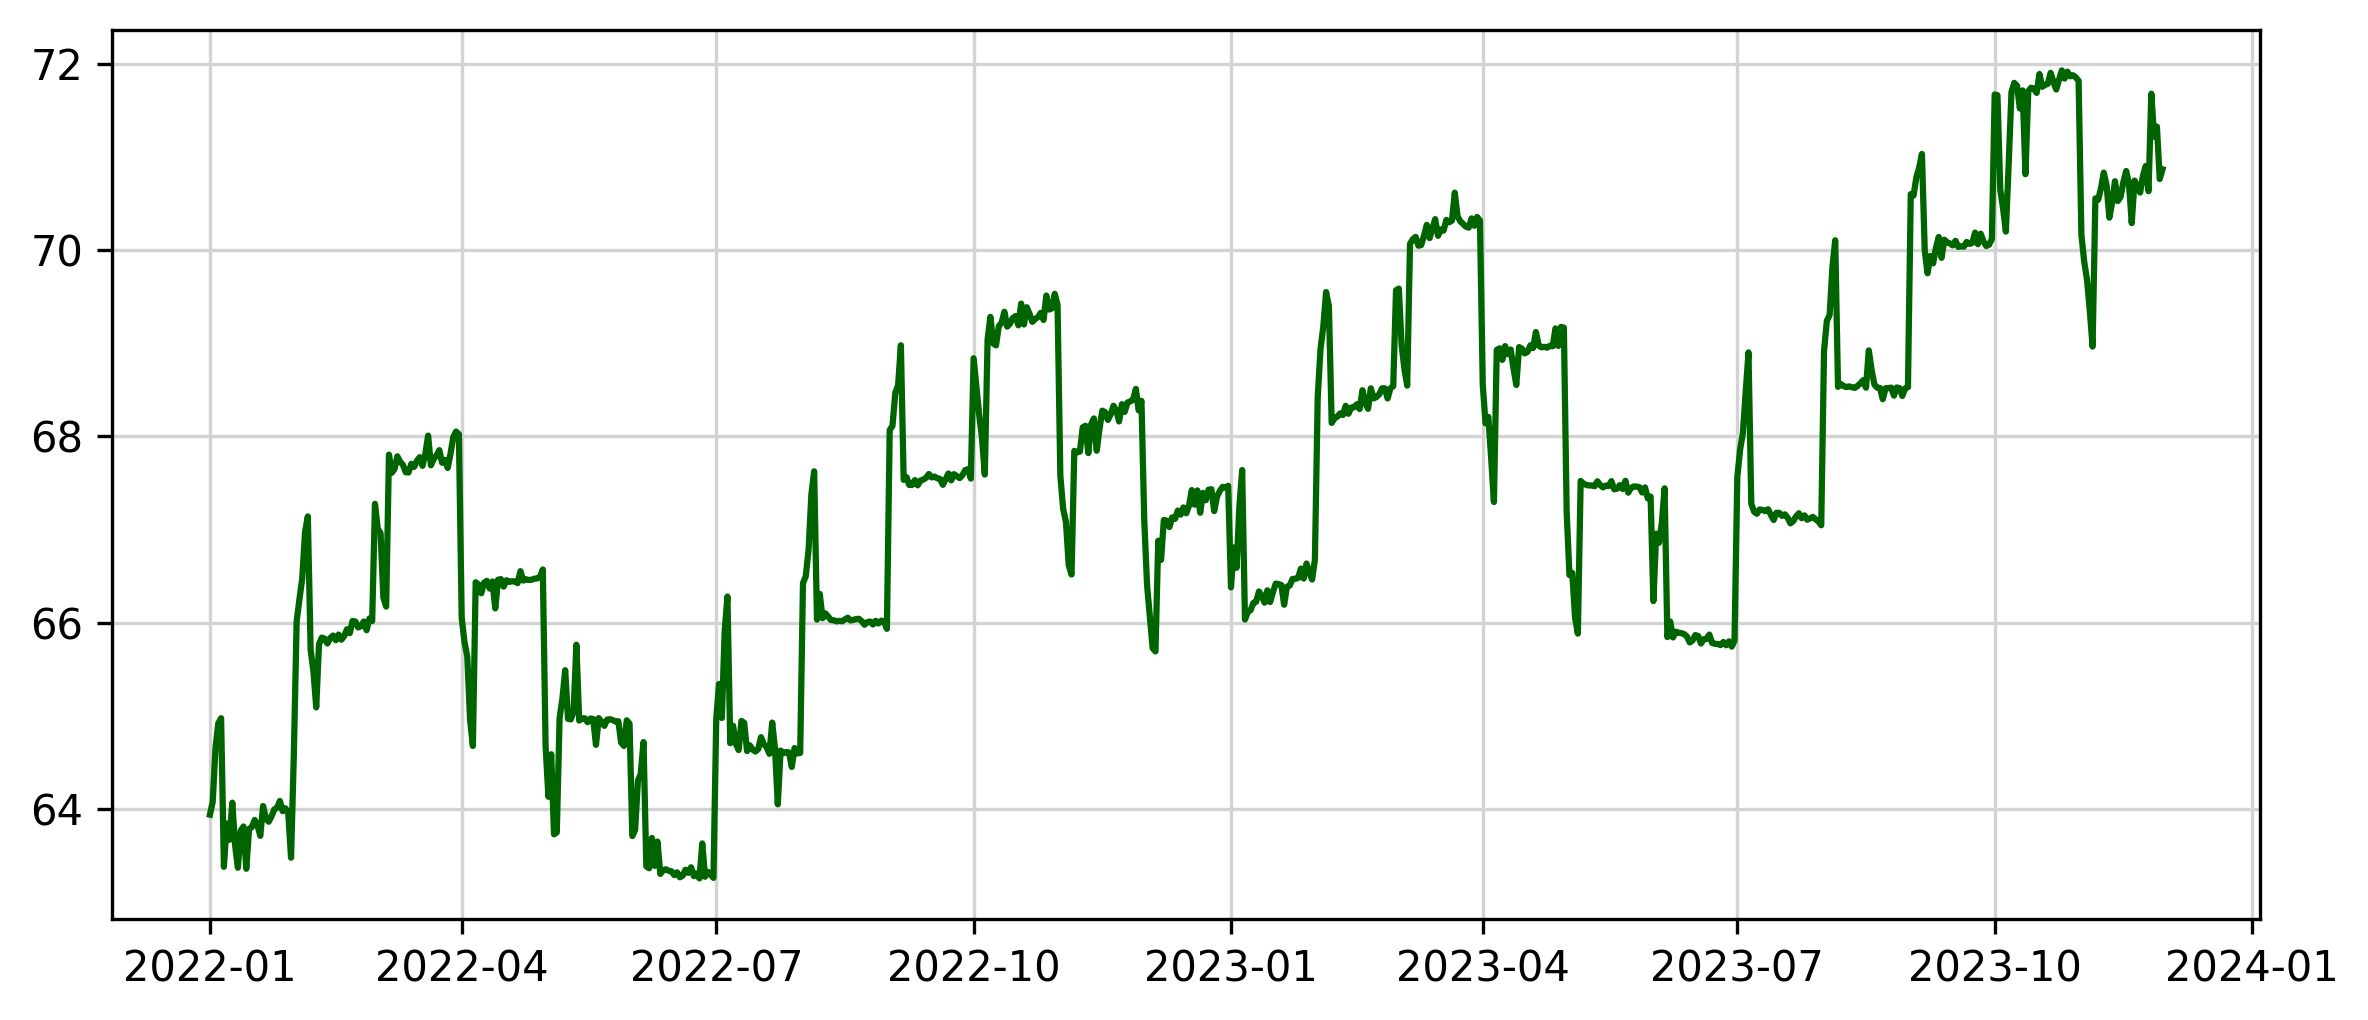

In [3]:
# Plotting the time series
plt.figure(figsize=(8, 3.5), dpi=300)
plt.plot(df.index, df['Score'], color='darkgreen')

# Make the grid light grey
plt.grid(color='lightgrey')
plt.xlabel('')
plt.ylabel('')
plt.grid(True)
plt.tight_layout()  # Adjust layout for better fit
plt.show()


## ④　Model Training

In [4]:
# Models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Ensemble Learning
from sklearn.ensemble import StackingRegressor

# Check the number of test data
horizon = df_test.shape[0]
train = df['Score'][:-horizon]
test = df['Score'][-horizon:]

# Model Selection and Hyperparameter Tuning
gb_model = GradientBoostingRegressor()
rf_model = RandomForestRegressor()

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_result_gb = grid_search_gb.fit(train.index.values.reshape(-1, 1), train.values)

In [5]:
best_params_gb = grid_result_gb.best_params_
gb_model.set_params(**best_params_gb)

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_result_rf = grid_search_rf.fit(train.index.values.reshape(-1, 1), train.values)

best_params_rf = grid_result_rf.best_params_
rf_model.set_params(**best_params_rf)

# Ensemble Learning (Stacking)
estimators = [
    ('gb', gb_model),
    ('rf', rf_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = cross_val_score(stacking_model, train.index.values.reshape(-1, 1), train.values, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.2f}, Std RMSE: {std_rmse:.2f}")

Mean RMSE: 1.37, Std RMSE: 0.56


In [6]:
# Model Fitting
stacking_model.fit(train.index.values.reshape(-1, 1), train.values)

StackingRegressor(estimators=[('gb',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=7,
                                                         n_estimators=200)),
                              ('rf',
                               RandomForestRegressor(max_depth=7,
                                                     n_estimators=200))],
                  final_estimator=LinearRegression())

## ⑤　Making Prediction

In [7]:
# Forecasting
forecast = stacking_model.predict(df_test.index.values.reshape(-1, 1))

# Print the forecast
print(forecast)

[69.92598893 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893
 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893
 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893
 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893
 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893 69.92598893
 69.92598893]


## ⑥　Exploratory Data Analysis (Post-Training)

In [8]:
# import matplotlib.pyplot as plt

# # Plotting the time series
# plt.figure(figsize=(8, 3), dpi=300)
# plt.plot(train, label='Training Data', color='darkgreen', alpha=0.5)
# plt.plot(test.index, test, label='Test Data', color='darkgreen', alpha=0.5)

# # Plot the forecasted data
# plt.plot(test.index, blended_preds, label='Forecast', color='purple', alpha=0.75)

# # Make the grid light grey
# plt.grid(color='lightgrey')
# plt.xlabel('')
# plt.ylabel('')
# plt.grid(True)
# plt.tight_layout()  # Adjust layout for better fit
# plt.show()

## ⑦　Submitting the Prediction

In [9]:
# Make DataFrame for Submission
submission = pd.DataFrame(forecast, index=df_test.index, columns=[target_col])

# Make a CSV file for Submission
submission.to_csv('submission.csv')

submission

,Score
Date,
2023-12-01,69.925989
2023-12-02,69.925989
2023-12-03,69.925989
2023-12-04,69.925989
2023-12-05,69.925989
2023-12-06,69.925989
2023-12-07,69.925989
2023-12-08,69.925989
2023-12-09,69.925989
